The following cell is just me checking whether I have everything linked to each other correctly.


In [1]:
import sys
if sys.version=='2.7.9 (v2.7.9:648dcafa7e5f, Dec 10 2014, 10:10:46) \n[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]':
    pass
else:
    raise Warning('Python version may not be compatible with Galsim')

In [2]:
sys.path=[]
for i in ['/Users/myhome/Library/Python/2.7/lib/python/site-packages/','/usr/local/lib/','/usr/local/lib/wxPython-3.0.0.0/lib/python2.7/site-packages', '/usr/local/lib/wxPython-3.0.0.0/lib/python2.7/site-packages/wx-3.0-osx_cocoa', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/FontTools', '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/VPython-6.11-py2.7-macosx-10.6-intel.egg', '/usr/local/lib/wxPython-3.0.0.0/lib/python2.7', '/Library/Python/2.7/site-packages', '/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python', '/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/PyObjC']:
    sys.path.append(i)
import galsim, os, math
from astropy.io import fits
import pandas as pd
%pylab inline
import seaborn as sns; sns.set_style('darkgrid')
import pyccl as ccl

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Populating the interactive namespace from numpy and matplotlib


The function simple_galsim (should probably find a better name eventually) takes most of the parameters as arguments. The default settings is a shear of $g_1=0.1$, $g_2=0.2$, $SNR = 100$, galaxy radius $= 2.7$, flux of $10^5$ photons.

The code creates a galaxy with an exponential profile (or a Gaussian or uses a real galaxy, depending on whether those arguments are set to True). It shears is with g1 and g2, then convolves it with a gaussian PSF. It then adds Gaussian noise with a certain SNR and a certain standard deviation. It finally calculates the moments, the shears, and saves the image of the galaxy.


In [3]:
def simple_galsim(exponential_galaxy=False,param=False,cosmos=False,directory='./', im_size=64,real_galaxy=False, gaussian_galaxy=False, gal_sigma=2,gal_r0=2.7, pixel_scale=0.2,psf_sigma=1,gal_flux=1.e5, snr=100, num=10, **kwargs):
    if type(directory)==str:
        pass
    else:
        raise TypeError('Directory must be a string.')
    if directory[-1]=='/':
        pass
    else:
        directory = directory+'/'
    real_gal,param_gal,wrong_result_shear, wrong_psf_im, psf_im, noise, image, result_moments, result_shear = [[0 for _ in range(num)] for _ in range(9)]
    noise_array = np.ones(num)*np.random.rand(num)*2
    for i in range(num):
        noise[i] = 30.*noise_array[i]
    
    # Define the galaxy profile
    im = galsim.Image(im_size, im_size)


    if gaussian_galaxy==True:
        gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
        gal_im = gal.drawImage(scale=pixel_scale)

    elif real_galaxy==True:
        gal = galsim.RealGalaxy(**kwargs)
        gal_im = gal.drawImage(scale=pixel_scale)
    elif exponential_galaxy==True: 
        gal = galsim.Exponential(flux=gal_flux,scale_radius=gal_r0)
        gal = gal.shear(g1=np.random.rand()/50 + 0.1, g2=np.random.rand()/50+0.1)
        gal_im = gal.drawImage(scale=pixel_scale)
    elif cosmos==True:
        cosmos_idx = np.arange(num)
        cosmos_cat = galsim.COSMOSCatalog()
        real_gal_list = cosmos_cat.makeGalaxy(cosmos_idx, gal_type='real',noise_pad_size=im_size*pixel_scale)
        param_gal_list = cosmos_cat.makeGalaxy(cosmos_idx, gal_type='parametric', chromatic=False)
        for i in range(len(cosmos_idx)):
            real_gal_list[i] = real_gal_list[i].drawImage(im,scale=pixel_scale)
            param_gal_list[i] = param_gal_list[i].drawImage(im,scale=pixel_scale)
    else:
        raise Error('type of galaxy not specified.')
        
    # Define the PSF profile
    psf_variations = np.random.uniform(0.95,1.05, num)
    wrong_psf_variations = np.random.uniform(0.9,1.1,num)
    for i in range(len(psf_variations)):
        psf = galsim.Gaussian(flux=1., sigma=psf_sigma*psf_variations[i]) # PSF flux should always = 1
        psf_im[i] = psf.drawImage(scale=pixel_scale)
        psf2 = galsim.Gaussian(flux=1.,sigma=psf_sigma*wrong_psf_variations[i])
        wrong_psf_im[i] = psf2.drawImage(scale=pixel_scale)
   
    # Final profile is the convolution of these
    if cosmos==True:
        for i in cosmos_idx:
            if param==True:
                final[i] = galsim.Convolve([param_gal_list[i], psf_im[i]])
            else:
                final[i] = galsim.Convolve([real_gal_list[i], psf_im[i]])
            image[i] = final[i].drawImage(scale=pixel_scale)
        # Draw the image with a particular pixel scale, given in arcsec/pixel.
    else:
        for i in range(num):
            image[i] = final.drawImage(scale=pixel_scale)

    # Add Gaussian noise to the image with specified sigma
    for i in range(num):
        image[i].addNoiseSNR(galsim.GaussianNoise(sigma=noise[i]), snr)
    # Write the image to a file
    if os.path.exists(directory)==True:
        pass
    else:
        os.mkdir(directory)
    for i in range(num):
        file_name = directory+'test'+str(i)+'.fits'
        image[i].write(file_name)
    
    for i in range(num):
        result_moments[i] = image[i].FindAdaptiveMom(strict=False)
        result_shear[i] = galsim.hsm.EstimateShear(image[i],psf_im[i],strict=False)
        wrong_result_shear[i] = galsim.hsm.EstimateShear(image[i],wrong_psf_im[i], strict=False)
    return result_moments, result_shear,wrong_result_shear,num

So, using the function above to create 100 galaxies:

In [7]:
moms,shears,wrong_shears,num = simple_galsim(exponential_galaxy=True,directory='new/',snr=100,num=20,gal_r0=0.5)

NameError: global name 'final' is not defined

We can get e.g. the shears from all the galaxies and make a 2-d histogram out of them. To test the sensitivity of the corrections to the wrong PSF, the function will return some wrong shears, where the psf used for the correction is wrong by ±10%. I will also extract those from the results.

In [ ]:
e1 = np.ones(num)
e2 = np.ones(num)
wrong_e1 = np.ones(num)
wrong_e2 = np.ones(num)
for i in range(num):
    e1[i] = shears[i].corrected_e1
    e2[i] = shears[i].corrected_e2
    wrong_e1[i] = wrong_shears[i].corrected_e1
    wrong_e2[i] = wrong_shears[i].corrected_e2

In [ ]:
for i in range(len(wrong_shears)):
    if ((wrong_shears[i].error_message=='')&(shears[i].error_message=='')):
        pass
    else:
        print i,wrong_shears[i].error_message
        wrong_shears = np.delete(wrong_shears,i)
        shears = np.delete(shears,i)
        moms = np.delete(moms,i)
        num = num-1

First, a plot of the corrected shears

In [ ]:
sns.jointplot(x=e1, y=e2, kind="hex", color="k")


Now, the corrected shears from the wrong psf models:

In [ ]:
print wrong_e2

In [ ]:
idx = np.where(np.logical_and(wrong_e1>-1,wrong_e2>-1))
sns.jointplot(x=wrong_e1[idx], y=wrong_e2[idx], kind="hex", color="k")


and a plot of the different between the two:

In [ ]:
e1_dif = e1-wrong_e1
e2_dif = e2-wrong_e2
sns.jointplot(x=e1_dif, y=e2_dif, kind="hex", color="k")

We can also show the images of the galaxies using:

In [ ]:
def plot_gal(num):
    num = str(num)
    fits_im = fits.open('new/test'+num+'.fits')
    plt.figure()
    plt.imshow(fits_im[0].data,cmap='viridis')
    plt.colorbar()
    plt.xlabel(r'$\times 0.2$ arcsec')
    plt.ylabel(r'$\times 0.2$ arcsec')
plot_gal(1);plot_gal(7);plot_gal(5)

and get some statistics such as the standard deviation:

In [ ]:
stds = np.ones(num)
for i in range(num):
    stds[i] = moms[i].moments_sigma
plt.hist(stds,bins = 20)
plt.xlabel(r'$\sigma$')

and the 4th radial moment $\rho_4$

In [ ]:
rho4s = np.ones(num)
for i in range(num):
    rho4s[i] = moms[i].moments_rho4
plt.hist(rho4s,bins = 20)
plt.xlabel(r'$\rho_4$')

In [4]:
p = ccl.Parameters(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)
cosmo = ccl.Cosmology(p, transfer_function='boltzmann')


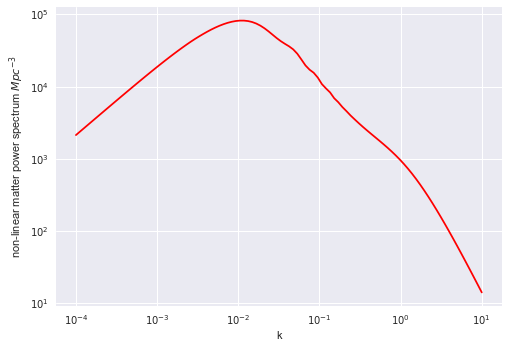

In [5]:
k = np.logspace(-4., 1., 100) # Wavenumber
a = 1.
pk_nl = ccl.nonlin_matter_power(cosmo, a, k)
plt.plot(k, pk_nl, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel(r'non-linear matter power spectrum $Mpc^{-3}$')

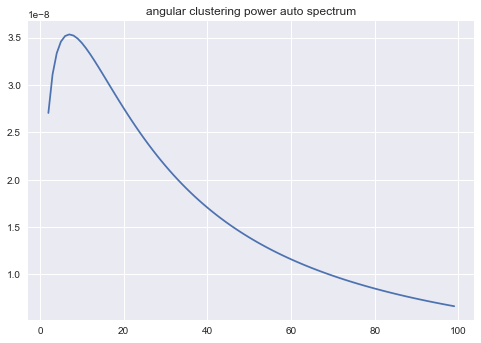

In [6]:
z = np.linspace(0., 3., 200)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

lens1 = ccl.ClTracerLensing(cosmo, False, z, dNdz)
lens2 = ccl.ClTracerLensing(cosmo, False, z, dNdz)
ell = np.arange(2, 100)
cls = ccl.angular_cl(cosmo, lens1, lens2, ell)
plt.plot(ell, cls)
plt.title('angular clustering power auto spectrum')

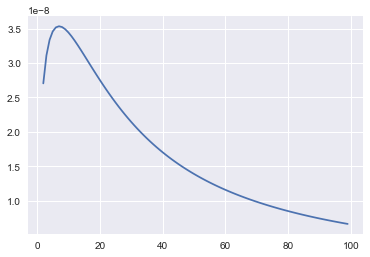

In [5]:
p = ccl.Parameters(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)
cosmo = ccl.Cosmology(p, transfer_function='boltzmann')
z = np.linspace(0., 3., 200)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

tracer1 = ccl.ClTracer(cosmo,tracer_type='lensing',n=[z,dNdz])
tracer2 = ccl.ClTracer(cosmo,tracer_type='lensing',n=dNdz,z=z)

ell = np.arange(2, 100)
cls = ccl.angular_cl(cosmo, tracer1, tracer2, ell)
plt.plot(ell, cls)
